# Example of loading, and running the Bandit models

In [1]:
# The First-Explore bandit architecture to enable evaluating trained runs

import os  # ensure we can import the lte_code
import sys
sys.path.append(os.getcwd()+"/..")
sys.path


from lte_code.bandit import MeanBandit
import jax
import jax.numpy as jnp
ACT_DIM = 10

from lte_code.lte_model3 import LTE
from transformers import DecisionTransformerConfig

## note the 4 here!
config = DecisionTransformerConfig(act_dim=ACT_DIM, state_dim=1)
num_training_steps = 1000*1000

import optax
def warmup_linear_schedule(
    learning_rate: float,
    total_steps: int,
    warmup_ratio: int):
    warmup_steps = int(total_steps*warmup_ratio)
    schedules = [
      optax.linear_schedule(
          init_value=0,
          end_value=learning_rate,
          transition_steps=warmup_steps),
      optax.linear_schedule(
          init_value=learning_rate,
          end_value=0,
          transition_steps= total_steps - warmup_steps),]
    return optax.join_schedules(schedules, [warmup_steps])


schedule = warmup_linear_schedule(learning_rate=1e-5,
                                  total_steps=num_training_steps,
                                  warmup_ratio=0.1)
optimizer = optax.chain(
  optax.clip(0.25),
  optax.adamw(learning_rate=schedule, weight_decay=1e-4),
)

In [2]:
config = DecisionTransformerConfig(act_dim=ACT_DIM, state_dim=ACT_DIM, n_head=4)
model = LTE(config)
key = jax.random.PRNGKey(0)
pkey, key = jax.random.split(key)

# to train first model
new_params = model.init(key)
opt_state = optimizer.init(new_params)
carry = (new_params, opt_state, key)

In [3]:
# define the two bandit environments.
# Note a meta_reset essentialy samples a new bandit environments from the relevant distribution

control_env = MeanBandit(key=jax.random.PRNGKey(42), n=ACT_DIM, minval=0) # minval is $mu_1$
cruel_env = MeanBandit(key=jax.random.PRNGKey(42), n=ACT_DIM, minval=0.5)
ENV = cruel_env

batch_step = jax.vmap(ENV.step)
batch_cruel_mset = jax.vmap(cruel_env.meta_reset)
batch_contr_mset = jax.vmap(control_env.meta_reset)

batch_step = jax.vmap(ENV.step)
BATCH_SIZE = 128

In [4]:
# lots of functions to perform rollouts
# regretably the code is duplicated (e.g., in the training scripts)

def reward_sequence(states, actions):
    """takes a batch of states
    and a batch of actions [batch_dim, seq_len, act_dim]
    and calculates the rewards, [batch_dim, seq_len, rewards]"""
    def step_state_reward(state, action):
        state = batch_step(state, action)
        return state, state.reward
    states, rewards = jax.lax.scan(step_state_reward,
                                   states,
                                   jnp.swapaxes(actions, 0, 1))
    return jnp.swapaxes(rewards, 0, 1)[..., 0]

def max_in_seq(values):
    """takes a batch of values [batch_dim, seq_len]
    and calculates the the running maximums along the seq_len"""
    def run_max(max_, val):
        max_ = jnp.maximum(max_, val)
        return max_, max_
    return jnp.swapaxes(jax.lax.scan(run_max, -jnp.inf+jnp.zeros(values.shape[0]),
                        jnp.swapaxes(values, 0, 1))[1],
                        0, 1)

def tokenize(actions_batch, rewards_batch):
    @jax.vmap
    @jax.vmap
    def one_hot(act):
        return jnp.zeros(shape=ACT_DIM).at[act].set(1)
    action_tokens = one_hot(actions_batch)
    reward_tokens = jnp.expand_dims(rewards_batch, 2)
    return action_tokens, reward_tokens


from functools import partial

import flax
def epsilon_samp(logits, e):
    p = flax.linen.activation.softmax(logits)
    return jnp.log((1-e)*p+e*jnp.ones(logits.shape)/logits.shape[-1])

@partial(jax.jit, static_argnames=('argmax', 'epsilon', 'greater'))
def exploit(model_params, states, actions, rewards, key,
            running_max, argmax=False, greater=False,
            epsilon=0):
    """Exploiting at each step of the sequence
    return the rewards, and the loss"""    
    action_tokens, reward_tokens = tokenize(actions_batch=actions,
                                            rewards_batch=rewards)
    batch_size, seq_len, act_dim = action_tokens.shape
    action_tokens = jnp.concatenate((jnp.zeros((batch_size, 1, act_dim)),
                                     action_tokens), axis=1)
    reward_tokens = jnp.concatenate((jnp.zeros((batch_size, 1, 1)),
                                     reward_tokens), axis=1)

    time_steps = jnp.zeros((batch_size, seq_len+1), dtype=int).at[:].set(jnp.arange(seq_len+1))
    hidden_state = model.apply(model_params,
                               actions=action_tokens,
                               rewards=reward_tokens,
                               position_ids=time_steps).last_hidden_state
    max_logits = model.pred_max.apply(model_params['pred_max'],
                                      hidden_state)
    nonmax_logits = model.pred_nonmax.apply(model_params['pred_nonmax'],
                                            hidden_state)
    ckey, ukey, rkey = jax.random.split(key, 3)
    if epsilon > 0:
        sample_logits = jax.lax.stop_gradient(epsilon_samp(max_logits, epsilon))
    else:
        sample_logits = jax.lax.stop_gradient(max_logits)
    if not argmax:
        m_actions = jax.random.categorical(logits=sample_logits, key=ckey, axis=-1)
    else:
        m_actions = jnp.argmax(max_logits, axis=-1)

    m_rewards = reward_sequence(states, m_actions)
    running_max = jnp.append((jnp.zeros((batch_size,1))-jnp.inf), running_max, axis=1)
    
    if greater:
        action_preds = jnp.where(jnp.expand_dims(m_rewards > running_max, 2),
                                 max_logits, nonmax_logits)
    else:
        action_preds = jnp.where(jnp.expand_dims(m_rewards >= running_max, 2),
                                 max_logits, nonmax_logits)
    ## important sanity step here stopping the gradients
    loss = optax.softmax_cross_entropy_with_integer_labels(action_preds+sample_logits,
                                                           jax.lax.stop_gradient(m_actions)).mean()
    return m_rewards, loss

In [5]:
### Functions for autoregressive sampling

from flax.core.frozen_dict import unfreeze, freeze
def feed_token(model_params, cache,
               actions, rewards, position_ids):
    """takes the parameters, the current model cache,
    the token, token_type, and time_step
    and feeds them to the model updating the cache
    
    Note, can process multiple tokens at once
    token should be [batch_size, seq_len, token_dim]
    and token_type [batch_size, seq_len]
    time_step [batch_size, seq_len]"""
    ra = unfreeze(model_params)
    ra['seq']['cache'] = cache['cache']
    return model.apply(params=ra, mutable=['cache'],
                       actions=actions,
                       rewards=rewards,
                       position_ids=position_ids)

SEQ_LEN = 100

from functools import partial
@partial(jax.jit, static_argnames="batch_size")
def init_cache(model_params, batch_size):
    return model.apply(
        params=model_params,
        init_cache=True,
        mutable=['cache'],
        actions=jnp.zeros((batch_size, SEQ_LEN, ACT_DIM)),
        rewards=jnp.zeros((batch_size, SEQ_LEN, 1)),
        position_ids=jnp.zeros((batch_size, SEQ_LEN), dtype=int),
    )[1]

batch_size = 128
CACHE = freeze(init_cache(new_params, batch_size))

In [6]:
@partial(jax.jit, static_argnames=("batch_size", "argmax", "pred_f1", "pred_f2", "pred_f3"))
def autoregressive_rollout(model_params, key, batch_size, state,
                           pred_f1, pred_f2, pred_f3, argmax=False,
                           seq_len=SEQ_LEN):
    """function to do a rollout given a policy
    
    model_params specifies the model parameters
    key is the jax.random.PRNGKey to seed the rng
    batch_size is batch_size
    state is the initial environment state
    and pred_f is the function that maps 
    the model hidden state to action probabilities
    argmax is whether to select the most probable action
    or to sample
    and epsilon is the probability of random action selection"""
    cache = init_cache(model_params, batch_size)
    act_token = jnp.zeros((batch_size, 1, ACT_DIM))
    reward_token = jnp.zeros((batch_size, 1, 1))
    time_step = jnp.zeros((batch_size, 1))
    m_key, a_key, a2_key = jax.random.split(key, 3)
    cache = init_cache(model_params, batch_size)
    carry = act_token, reward_token, time_step, cache, state

    def one_step(carry, key):
        act_token, reward_token, time_step, cache, state = carry
        ans, cache = feed_token(model_params=model_params,
                                cache=cache,
                                actions=act_token,
                                rewards=reward_token, 
                                position_ids=time_step)
        hidden_state = ans.last_hidden_state
        # batch_size, seq_len, act_dim
        logits = pred_f1(hidden_state[:, -1, ...])
        logits_2 = pred_f2(hidden_state[:, -1, ...])
        logits_3 = pred_f3(hidden_state[:, -1, ...])
        ckey, ukey, rkey = jax.random.split(key, 3)
        if not argmax:
            actions = jax.random.categorical(logits=logits,
                                             key=ckey, axis=-1)
        else:
            actions = jnp.argmax(logits, axis=-1)
        state = batch_step(state, actions)
        
        @jax.vmap
        def one_hot(act):
            return jnp.zeros(shape=ACT_DIM).at[act].set(1)
        act_token = jnp.expand_dims(one_hot(actions), 1)
        reward_token = jnp.expand_dims(state.reward, 1)
        time_step = time_step+1
        return ((act_token, reward_token, time_step, cache, state),
                (actions, state.reward[:, 0], logits, logits_2, logits_3))
    carry, x = one_step(carry, a_key)
    _, xs = jax.lax.scan(one_step, carry, 
                         jax.random.split(a2_key, seq_len-1))
    xs = jax.tree_map(lambda a, b :jnp.swapaxes(jnp.append(jnp.expand_dims(a, 0),
                                                                         b, axis=0),
                                                              0, 1), 
                                    x, xs)
    return xs

In [7]:
@partial(jax.jit, static_argnames=("batch_size", "argmax", "pred_f1", "pred_f2", "pred_f3", "seq_len"))
def autoregressive_rollout_with_carry(carry, 
                                      model_params, key, batch_size, state,
                                      pred_f1, pred_f2, pred_f3, argmax=False,
                                      seq_len=SEQ_LEN):
    """function to do a rollout given a policy
    
    model_params specifies the model parameters
    key is the jax.random.PRNGKey to seed the rng
    batch_size is batch_size
    state is the initial environment state
    and pred_f is the function that maps 
    the model hidden state to action probabilities
    argmax is whether to select the most probable action
    or to sample
    and epsilon is the probability of random action selection"""
    def one_step(carry, key):
        act_token, reward_token, time_step, cache, state = carry
        ans, cache = feed_token(model_params=model_params,
                                cache=cache,
                                actions=act_token,
                                rewards=reward_token, 
                                position_ids=time_step)
        hidden_state = ans.last_hidden_state
        # batch_size, seq_len, act_dim
        logits = pred_f1(hidden_state[:, -1, ...])
        logits_2 = pred_f2(hidden_state[:, -1, ...])
        logits_3 = pred_f3(hidden_state[:, -1, ...])
        ckey, ukey, rkey = jax.random.split(key, 3)
        if not argmax:
            actions = jax.random.categorical(logits=logits,
                                             key=ckey, axis=-1)
        else:
            actions = jnp.argmax(logits, axis=-1)
        state = batch_step(state, actions)
        
        @jax.vmap
        def one_hot(act):
            return jnp.zeros(shape=ACT_DIM).at[act].set(1)
        act_token = jnp.expand_dims(one_hot(actions), 1)
        reward_token = jnp.expand_dims(state.reward, 1)
        time_step = time_step+1
        return ((act_token, reward_token, time_step, cache, state),
                (actions, state.reward[:, 0], logits, logits_2, logits_3))
    
    m_key, a_key, a2_key = jax.random.split(key, 3)
    carry, x = one_step(carry, a_key)
    carry, xs = jax.lax.scan(one_step, carry, 
                         jax.random.split(a2_key, seq_len-1))
    xs = jax.tree_map(lambda a, b :jnp.swapaxes(jnp.append(jnp.expand_dims(a, 0),
                                                                         b, axis=0),
                                                              0, 1), 
                                    x, xs)
    return carry, xs

In [8]:
# this is the function used to actually sample!!

def explore_then_exploit(model_loit_params,
                         model_lore_params,
                         states, batch_size, key, e_epsilon=0, m_epsilon=0,
                         e_argmax=True, m_argmax=True,
                         k=10):
    """explores autoregressively from the states
    and then exploits autoregressively"""
    
    rollout_key, exploit_key = jax.random.split(key, 2)
    ### generate the explore sequence
    
#     @jax.jit
    def predf1(hidden_state): 
        logits = model.pred_exp.apply(model_lore_params['pred_exp'],
                                              hidden_state)
        logits = jax.lax.stop_gradient(epsilon_samp(logits, e_epsilon))
        return logits
    
#     @jax.jit
    def predf2(hidden_state): 
        logits = model.pred_nonexp.apply(model_lore_params['pred_max'],
                                         hidden_state)
        return logits
    
    def predf3(hidden_state): 
        logits = model.pred_nonexp.apply(model_lore_params['pred_nonexp'],
                                         hidden_state)
        return logits

    
    cache = init_cache(model_lore_params, batch_size)
    act_token = jnp.zeros((batch_size, 1, ACT_DIM))
    reward_token = jnp.zeros((batch_size, 1, 1))
    time_step = jnp.zeros((batch_size, 1))
    key1, key2 = jax.random.split(rollout_key, 2)
    carry = act_token, reward_token, time_step, cache, states
    

    carry, (actions, rewards, sample_logits, logits2, logits3) =\
    autoregressive_rollout_with_carry(carry=carry,
                                      model_params=model_lore_params,
                                      key=key1,
                                      batch_size=batch_size,
                                      state=states,
                                      pred_f1=predf1,
                                      pred_f2=predf1,
                                      pred_f3=predf1,
                                      argmax=e_argmax,
                                      seq_len=k)
    
    # exploit
    carry, (actions_2, rewards_2, sample_logits_2, logits2_2, logits3_2) =\
    autoregressive_rollout_with_carry(carry=carry,
                                      model_params=model_loit_params,
                                      key=key2,
                                      batch_size=batch_size,
                                      state=states,
                                      pred_f1=predf2,
                                      pred_f2=predf2,
                                      pred_f3=predf2,
                                      argmax=m_argmax,
                                      seq_len=SEQ_LEN - k)
    return rewards, rewards_2

### Example of Loading Saved Models and performing rollouts

In [9]:
import pickle
with open(f"n10_p100_b128_control_seed{42}/run_data.pkl", "rb") as file:
    data = pickle.load(file)
    first_explore_contr = data[0][0]

### Example of evaluating $k=10$ for the $\mu_0=0$ model on the $\mu_0=0$ environment

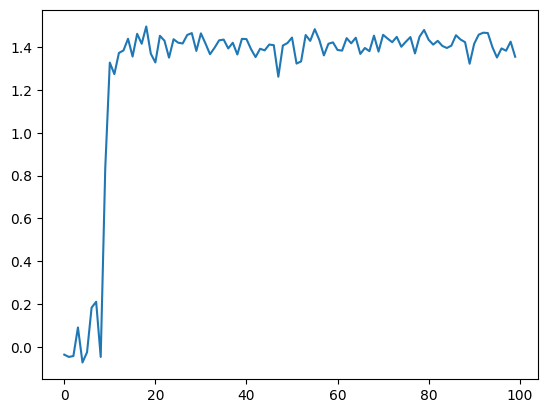

In [10]:
import jax.random as jr

# set the environment state (n.b., the two cases of domain both have the same step function
# they just differ initial environment state (the reward of the first arm)

bstate = batch_contr_mset(jr.split(jr.fold_in(jr.PRNGKey(0), 1), batch_size))
ans = explore_then_exploit(first_explore_contr,
                           first_explore_contr,
                           bstate, batch_size, jr.PRNGKey(0), k=10)

explore_rewards, exploit_rewards = ans

import numpy as np
rewards = np.concatenate((explore_rewards, exploit_rewards), axis=1)

import matplotlib.pyplot as plt

# plot the arm pull rewards
plt.plot(rewards.mean(axis=0))